In [ ]:
# Earnings Analysis 

In [25]:
!pip install yfinance  nasdaq-data-link quandl python-dotenv termcolor

## Stock Universe

In [27]:
# Cell 1: Import Libraries
import requests
import pandas as pd
import os
from dotenv import load_dotenv
from datetime import datetime
import io
import matplotlib.pyplot as plt
import calendar
import ipywidgets as widgets
from IPython.display import display
from termcolor import colored


# Load environment variables from .env file
load_dotenv()

# Read the API key from environment variable
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

{'Semiconductor': ['AMD', 'AEHR', 'MU', 'NVDA', 'QCOM', 'SMCI', 'CSCO', 'ON', 'DELL', 'ASML', 'MRVL', 'AVGO', 'MPWR', 'APLD', 'INTC'], 'Cybersecurity': ['FTNT', 'NET', 'PANW', 'CRWD'], 'Mag_7': ['NVDA', 'AAPL', 'TSLA', 'MSFT', 'AMZN', 'META', 'GOOG'], 'Crypto': ['RIOT', 'MSTR', 'HIVE', 'CLSK', 'BTBT', 'WULF', 'CORZ', 'COIN', 'SQ', 'IREN', 'HUT', 'MARA', 'SOS']}


## Earnings Calendar

In [36]:
# Function to fetch earnings calendar data
def fetch_earnings_calendar(symbol, api_key, horizon='3month'):
    url = f'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol={symbol}&horizon={horizon}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.content.decode('utf-8')
        return pd.read_csv(io.StringIO(data))
    else:
        print(f"Failed to fetch data for {symbol}. Status code: {response.status_code}")
        return None

# Function to fetch and organize earnings calendar data for baskets
def get_earnings_calendar(baskets, api_key, horizon=3):
    earnings_calendar = []
    end_date = datetime.now() + pd.DateOffset(months=horizon)
    for basket_name, symbols in baskets.items():
        for symbol in symbols:
            earnings = fetch_earnings_calendar(symbol, api_key, horizon=f'{horizon}month')
            if earnings is not None:
                for index, row in earnings.iterrows():
                    earnings_date = pd.to_datetime(row['reportDate'])
                    if earnings_date <= end_date:
                        earnings_calendar.append({
                            'Basket': basket_name,
                            'Symbol': symbol,
                            'Date': row['reportDate'],
                            'EPS': row.get('epsEstimate', 'N/A')  # Use .get() to avoid KeyError
                        })
    df = pd.DataFrame(earnings_calendar)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Function to print earnings calendar
def print_earnings_calendar(earnings_calendar_df):
    earnings_calendar_df['Date'] = pd.to_datetime(earnings_calendar_df['Date'])
    print(f"Earnings Calendar for the Next {horizon} Months:")
    for basket in earnings_calendar_df['Basket'].unique():
        print(f"\nBasket: {basket}")
        basket_data = earnings_calendar_df[earnings_calendar_df['Basket'] == basket].sort_values(by='Date')
        for index, row in basket_data.iterrows():
            print(f"Ticker: {row['Symbol']}, Earnings Date: {row['Date'].strftime('%Y-%m-%d')}, EPS Estimate: {row['EPS']}")

# Function to assign colors to each basket
def assign_text_colors(baskets):
    colors = ['red', 'green', 'yellow', 'blue', 'magenta', 'cyan']
    color_map = {basket: colors[i % len(colors)] for i, basket in enumerate(baskets)}
    return color_map

# Enhanced function to print earnings by date with colors
def print_earnings_by_date(earnings_calendar_df):
    earnings_calendar_df['Date'] = pd.to_datetime(earnings_calendar_df['Date'])
    grouped = earnings_calendar_df.groupby('Date').apply(lambda x: ', '.join(x['Symbol'] + ' (' + x['Basket'] + ')')).reset_index(name='Symbol')
    
    color_map = assign_text_colors(earnings_calendar_df['Basket'].unique())
    
    print("Earnings by Date:")
    for index, row in grouped.iterrows():
        symbols = row['Symbol']
        colored_symbols = []
        for symbol in symbols.split(', '):
            ticker, basket = symbol.split(' (')
            basket = basket.rstrip(')')
            colored_symbols.append(colored(ticker, color_map[basket]))
        print(f"{row['Date'].strftime('%Y-%m-%d')}: {', '.join(colored_symbols)}")
    
    print("\nLegend:")
    for basket, color in color_map.items():
        print(colored(basket, color))

### Define interested Stock Lists

In [42]:
# Cell 2 and 4 Combined: Define Stock Groups, Automate Dictionary Creation, and Create Baskets
semiconductor = ['NVDA', 'AVGO', 'AMD', 'DELL', 'MU', 'INTC', 'QCOM', 'CSCO', 'MRVL', 'SMCI', 'ASML', 'ON', 'MPWR', 'APLD', 'AEHR']
cybersecurity = ['PANW', 'NET', 'CRWD', 'FTNT','HACK','ZS']
mag_7 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOG', 'META', 'TSLA']
crypto = ['MARA', 'RIOT', 'HIVE', 'MSTR', 'HUT', 'IREN', 'SOS', 'WULF', 'CLSK', 'CORZ', 'BTBT', 'SQ', 'COIN']
software_ai = ['SNOW','HUBS','HCP','DUOL','SHOP','MDB','ORCL','CRM','DOCU','TWLO','KVYO','SNAP','NOW','DDOG','PLTR','CART']
energy=['CEG','VST']

def create_group(name, symbols):
    unique_symbols = list(set(symbols))  # Ensure unique tickers
    return {name: {'name': name.capitalize(), 'symbols': unique_symbols}}

# Function to create a basket of stocks
def create_basket(groups):
    basket = {}
    for group_name, symbols in groups.items():
        group = create_group(group_name, symbols)
        for name, group_info in group.items():
            basket[group_info['name']] = group_info['symbols']
    return basket

# Filter out Jupyter internal variables and dynamically retrieve group names and symbols
all_vars = globals()
groups = {k: v for k, v in all_vars.items() if isinstance(v, list) and k in ['semiconductor', 'cybersecurity', 'mag_7', 'crypto']}

# Create baskets
baskets = create_basket(groups)
print(baskets)  # To verify the structure

# The rest of the code remains unchanged

{'Semiconductor': ['AMD', 'AEHR', 'MU', 'NVDA', 'QCOM', 'SMCI', 'CSCO', 'ON', 'DELL', 'ASML', 'MRVL', 'AVGO', 'MPWR', 'APLD', 'INTC'], 'Cybersecurity': ['FTNT', 'HACK', 'NET', 'ZS', 'PANW', 'CRWD'], 'Mag_7': ['NVDA', 'AAPL', 'TSLA', 'MSFT', 'AMZN', 'META', 'GOOG'], 'Crypto': ['RIOT', 'MSTR', 'HIVE', 'CLSK', 'BTBT', 'WULF', 'CORZ', 'COIN', 'SQ', 'IREN', 'HUT', 'MARA', 'SOS']}


### Get and Print earnings dates

In [41]:
# Set the horizon in months
horizon = 3

# Define all groups (ensure this matches your basket groups)
all_groups = {
    'Semiconductor': semiconductor,
    'Cybersecurity': cybersecurity,
    'Mag_7': mag_7,
    'Crypto': crypto
}

# Create selected_baskets
selected_baskets = create_basket(all_groups)

# Fetch and organize the data
earnings_calendar_df = get_earnings_calendar(selected_baskets, api_key, horizon)

# Print the earnings calendar
# print_earnings_calendar(earnings_calendar_df)

# Print the earnings by date
print_earnings_by_date(earnings_calendar_df)

Earnings by Date:
2024-07-16: AEHR
2024-07-17: ASML, TSLA
2024-07-23: MSFT, GOOG
2024-07-29: ON, MPWR
2024-07-30: AMD, MSTR
2024-07-31: QCOM, META
2024-08-01: APLD, INTC, NET, AAPL, AMZN, COIN, SQ
2024-08-05: CORZ
2024-08-06: SMCI, FTNT, MARA
2024-08-07: RIOT, CLSK
2024-08-09: HIVE
2024-08-12: HUT
2024-08-13: BTBT
2024-08-14: CSCO
2024-08-16: PANW
2024-08-21: NVDA, NVDA
2024-08-22: MRVL
2024-08-28: CRWD
2024-08-29: DELL, AVGO
2024-09-13: IREN
2024-09-23: SOS
2024-09-25: MU
2024-10-03: AEHR
2024-10-07: APLD

Legend:
Semiconductor
Cybersecurity
Mag_7
Crypto


/var/folders/wd/r6dvw4896gxcrcr84m33fv240000gp/T/ipykernel_4434/291597966.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = earnings_calendar_df.groupby('Date').apply(lambda x: ', '.join(x['Symbol'] + ' (' + x['Basket'] + ')')).reset_index(name='Symbol')


### Plot Earnings Calendar

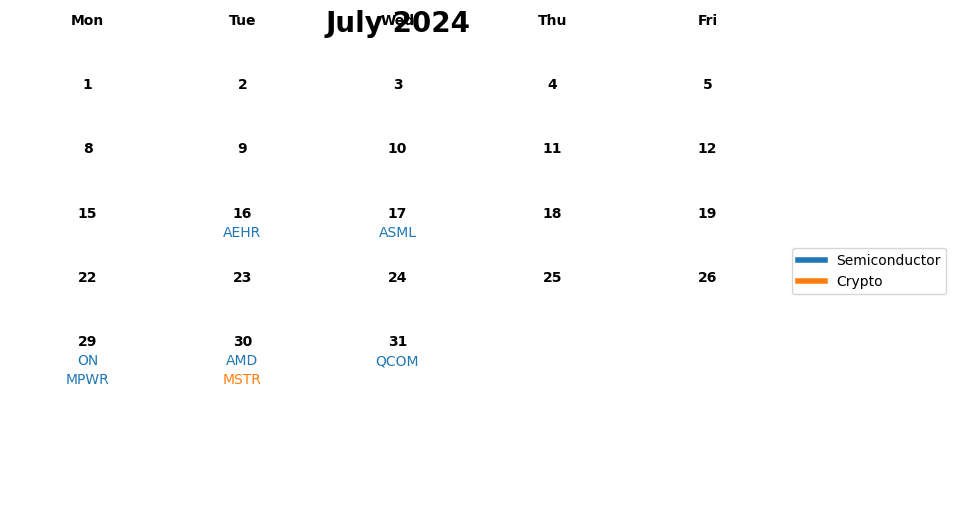

DateParseError: Unknown datetime string format, unable to parse: f, at position 0

DateParseError: Unknown datetime string format, unable to parse: f, at position 0

In [16]:
# Cell 5: Plot Earnings Calendar
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def assign_colors(baskets):
    cmap = plt.get_cmap('tab10')
    colors = cmap.colors[:len(baskets)]
    color_map = {basket: colors[i] for i, basket in enumerate(baskets)}
    return color_map

def plot_earnings_calendar(df, month, year, horizon=3):
    df['Date'] = pd.to_datetime(df['Date'])

    # Calculate the end date based on the horizon
    end_date = datetime.now() + pd.DateOffset(months=horizon)
    start_date = datetime.now()

    # Filter data for the given horizon
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Filter data for the given month and year
    month_df = df[(df['Date'].dt.month == month) & (df['Date'].dt.year == year)]
    
    # Create a calendar
    cal = calendar.monthcalendar(year, month)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted size to remove weekends
    ax.set_axis_off()
    
    # Define month and weekday names
    month_name = calendar.month_name[month]
    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    
    # Plot month name and year
    ax.set_title(f"{month_name} {year}", fontsize=20, weight='bold')
    
    # Plot weekdays
    for i, day in enumerate(weekdays):
        ax.text(i + 0.5, 6.5, day, ha='center', va='center', weight='bold')
    
    # Assign colors dynamically for each basket
    color_map = assign_colors(df['Basket'].unique())
    
    # Calculate the maximum number of tickers for any single day
    max_tickers = month_df.groupby(month_df['Date'].dt.day).size().max() if not month_df.empty else 0
    
    # Plot days, dates, and tickers
    for week_num, week in enumerate(cal):
        for day_num, day in enumerate(week[:5]):  # Only include Monday to Friday
            if day != 0:
                tickers = month_df[month_df['Date'].dt.day == day]
                date_text = f"{day}"
                ax.text(day_num + 0.5, 5.5 - week_num, date_text, ha='center', va='center', weight='bold')  # Plot the date
                if not tickers.empty:
                    for line_num, (idx, row) in enumerate(tickers.iterrows()):
                        ticker = row['Symbol']
                        basket_name = row['Basket']
                        color = color_map.get(basket_name, 'black')
                        ax.text(day_num + 0.5, 5.5 - week_num - (line_num + 1) * 0.3, ticker, ha='center', va='center', color=color)  # Plot each ticker below the date
    
    # Adjust plot limits based on the maximum number of tickers
    ax.set_xlim(0, 5)
    ax.set_ylim(-1, 6.5 - max(0, (max_tickers - 1) * 0.3))
    
    # Add a legend
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=basket) for basket, color in color_map.items()]
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot
    
    plt.show()

# Function to update calendar plot
def update_calendar(change):
    month = month_selector.value
    year = year_selector.value
    selected_lists = [checkbox.description for checkbox in list_selectors if checkbox.value]
    selected_baskets = create_basket({name: groups[name.lower()] for name in selected_lists})
    earnings_calendar_df = get_earnings_calendar(selected_baskets, api_key, horizon=horizon)
    clear_output(wait=True)
    display_controls()
    plot_earnings_calendar(earnings_calendar_df, month, year, horizon=horizon)

# Create interactive widgets for month, year selection, and list selection
month_selector = widgets.IntSlider(value=datetime.now().month, min=1, max=12, step=1, description='Month:')
year_selector = widgets.IntSlider(value=datetime.now().year, min=datetime.now().year - 1, max=datetime.now().year + 1, step=1, description='Year:')
list_selectors = [widgets.Checkbox(value=True, description=group) for group in all_groups.keys()]

# Function to display controls
def display_controls():
    control_box = widgets.VBox([month_selector, year_selector] + list_selectors)
    display(widgets.HBox([control_box]))

# Link the widgets to the update function
for selector in list_selectors:
    selector.observe(update_calendar, names='value')
month_selector.observe(update_calendar, names='value')
year_selector.observe(update_calendar, names='value')

# Display the initial controls
display_controls()
update_calendar(None)

## Generate Financial Data